In [2]:
import pandas as pd
from sqlalchemy import create_engine, text
from dotenv import dotenv_values
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [4]:

# Load database configuration from .env file
config = dotenv_values()
pg_user = config['POSTGRES_USER']
pg_host = config['POSTGRES_HOST']
pg_port = config['POSTGRES_PORT']
pg_db = config['POSTGRES_DB']
pg_pass = config['POSTGRES_PASS']
pg_schema = config['POSTGRES_SCHEMA']

# Create the connection URL
url = f'postgresql://{pg_user}:{pg_pass}@{pg_host}:{pg_port}/{pg_db}'
engine = create_engine(url, echo=False)

query = f"""
    SELECT *           
    FROM "{pg_schema}"."20241112_trainingdata"
"""

# Execute the query and load the result into a DataFrame
with engine.connect() as connection:
    df = pd.read_sql_query(text(query), connection)

# Save the DataFrame to CSV
df.to_csv("20241112_trainingdata.csv", index=False)


query = f"""
    SELECT *           
    FROM "{pg_schema}"."20241112_data_to_predict"
"""

#Execute the query and load the result into a DataFrame
with engine.connect() as connection:
    df = pd.read_sql_query(text(query), connection)

 #Save the DataFrame to CSV
df.to_csv("20241112_data_to_predict.csv", index=False)

In [4]:
df = pd.read_csv("20241111_trainingdata.csv")
df = df.dropna()

X = df.drop(columns=["ecosystem", "name"])
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["ecosystem"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Modellbewertung:\n", classification_report(y_test, y_pred))

merged_data_to_predict = pd.read_csv('20241111_data_to_predict.csv')
X_new = merged_data_to_predict.drop(columns=["ecosystem", "name"], errors='ignore')

X_new_scaled = scaler.transform(X_new)

y_new_pred = model.predict(X_new_scaled)

ecosystem_pred = label_encoder.inverse_transform(y_new_pred)

merged_data_to_predict['predicted_ecosystem'] = ecosystem_pred

print(merged_data_to_predict[['lat', 'lon', 'predicted_ecosystem']].head())


Modellbewertung:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        91
           1       1.00      1.00      1.00         9
           2       0.99      1.00      0.99       150
           3       1.00      1.00      1.00       490
           4       1.00      1.00      1.00        89
           5       1.00      1.00      1.00        58
           6       0.99      1.00      0.99        83
           7       1.00      1.00      1.00        85
           8       1.00      1.00      1.00       248
           9       1.00      1.00      1.00        20
          10       1.00      1.00      1.00       415
          11       1.00      1.00      1.00        12
          12       1.00      1.00      1.00        29
          13       0.96      0.99      0.97       156
          14       0.97      0.91      0.94        79

    accuracy                           0.99      2014
   macro avg       0.99      0.99      0.99      2014
weighted

In [8]:
# Rückumwandlung der numerischen Vorhersagen in die ursprünglichen Kategorien
ecosystem_pred = label_encoder.inverse_transform(y_new_pred)  # Verwende den gleichen LabelEncoder wie beim Training

# Hinzufügen der Vorhersage als neue Spalte
merged_data_to_predict['predicted_ecosystem'] = ecosystem_pred

# Überprüfen, ob die 'predicted_ecosystem'-Spalte korrekt hinzugefügt wurde
print(merged_data_to_predict.columns)  # Zeigt alle Spalten an
print(merged_data_to_predict[['lat', 'lon', 'predicted_ecosystem']].head(20))  # Zeigt die ersten Zeilen an
merged_data_to_predict = merged_data_to_predict.dropna(subset=['SWdown_min'])


Index(['lat', 'lon', 'elevation', 'radiance', 'ndvi', 'Swnet_min', 'Swnet_max',
       'Swnet_avg', 'Lwnet_min', 'Lwnet_max',
       ...
       'Psurf_avg', 'SWdown_min', 'SWdown_max', 'SWdown_avg', 'LWdown_min',
       'LWdown_max', 'LWdown_avg', 'ecosystem', 'name', 'predicted_ecosystem'],
      dtype='object', length=116)
       lat      lon       predicted_ecosystem
0  -65.125 -179.375  Natural-Grassland-Meadow
1  -65.125 -178.875  Natural-Grassland-Meadow
2  -65.125 -178.625  Natural-Grassland-Meadow
3  -65.125 -178.375  Natural-Grassland-Meadow
4  -65.125 -178.125  Natural-Grassland-Meadow
5  -65.125 -177.875  Natural-Grassland-Meadow
6  -65.125 -176.875  Natural-Grassland-Meadow
7  -65.125 -176.625  Natural-Grassland-Meadow
8  -65.125 -176.375  Natural-Grassland-Meadow
9  -65.125 -176.125  Natural-Grassland-Meadow
10 -65.125 -175.875  Natural-Grassland-Meadow
11 -65.125 -175.625  Natural-Grassland-Meadow
12 -65.125 -175.375  Natural-Grassland-Meadow
13 -65.125 -175.125  Natural-

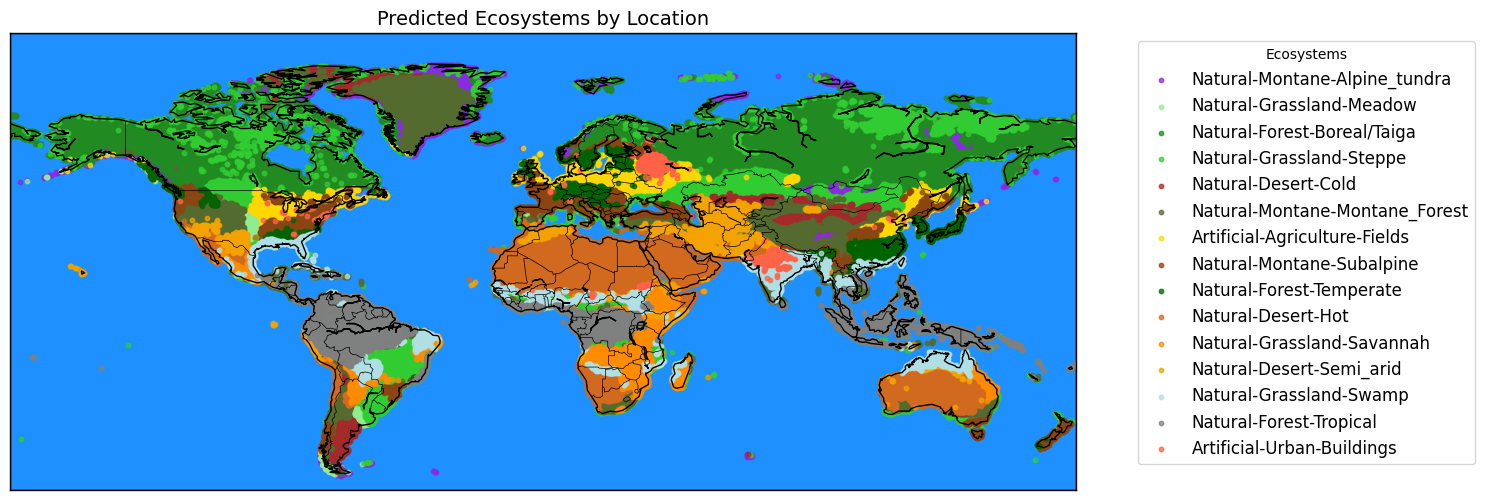

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.basemap import Basemap

# Set up the figure and Basemap for the World
plt.figure(figsize=(15, 10))
m_projection = "gall"  # Gall-Peters projection
m = Basemap(projection=m_projection, llcrnrlat=-60, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180)

# Draw coastlines and countries for reference
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='#1E90FF')  # Light Blue Ocean

# Define custom color palette for each ecosystem based on your predicted categories
ecosystem_color_map = {
    'Artificial-Urban-Buildings': '#FF6347',  # Red
    'Artificial-Agriculture-Fields': '#FFD700',  # Gold
    'Natural-Grassland-Steppe': '#32CD32',  # Lime Green
    'Natural-Forest-Boreal/Taiga': '#228B22',  # Forest Green
    'Natural-Forest-Temperate': '#006400',  # Dark Green
    'Natural-Desert-Hot': '#D2691E',  # Chocolate Brown
    'Natural-Desert-Cold': '#A52A2A',  # Brown
    'Natural-Grassland-Meadow': '#90EE90',  # Light Green
    'Natural-Grassland-Savannah': '#FF8C00',  # Dark Orange
    'Natural-Grassland-Swamp': '#B0E0E6',  # Powder Blue
    'Natural-Montane-Montane_Forest': '#556B2F',  # Dark Olive Green
    'Natural-Montane-Alpine_tundra': '#8A2BE2',  # Blue Violet
    'Natural-Desert-Semi_arid': '#F4A300',  # Orange Yellow
    'Natural-Montane-Subalpine': '#8B4513'   # Saddle Brown
    }

# Erstellen einer Liste von einzigartigen Ökosystemen aus den Vorhersagen
unique_ecosystems = merged_data_to_predict['predicted_ecosystem'].unique()

# Plot each point, colored by predicted ecosystem
scatter_objects = []  # To store scatter objects for the legend
for ecosystem in unique_ecosystems:
    ecosystem_data = merged_data_to_predict[merged_data_to_predict['predicted_ecosystem'] == ecosystem]
    x, y = m(ecosystem_data['lon'].values, ecosystem_data['lat'].values)
    # Get the color for this ecosystem from the predefined color map
    color = ecosystem_color_map.get(ecosystem, '#808080')  # Default to gray if not found
    # Create scatter for this ecosystem and add it to the legend
    scatter = m.scatter(x, y, color=color, s=10, alpha=0.75, label=ecosystem)
    scatter_objects.append(scatter)  # Store scatter object for later use in legend

# Add a title
plt.title("Predicted Ecosystems by Location", fontsize=14)

# Add a legend for the ecosystems
plt.legend(handles=scatter_objects, title="Ecosystems", loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=12)
# Show the plot
plt.tight_layout()  # Ensure the map fits well
plt.show()

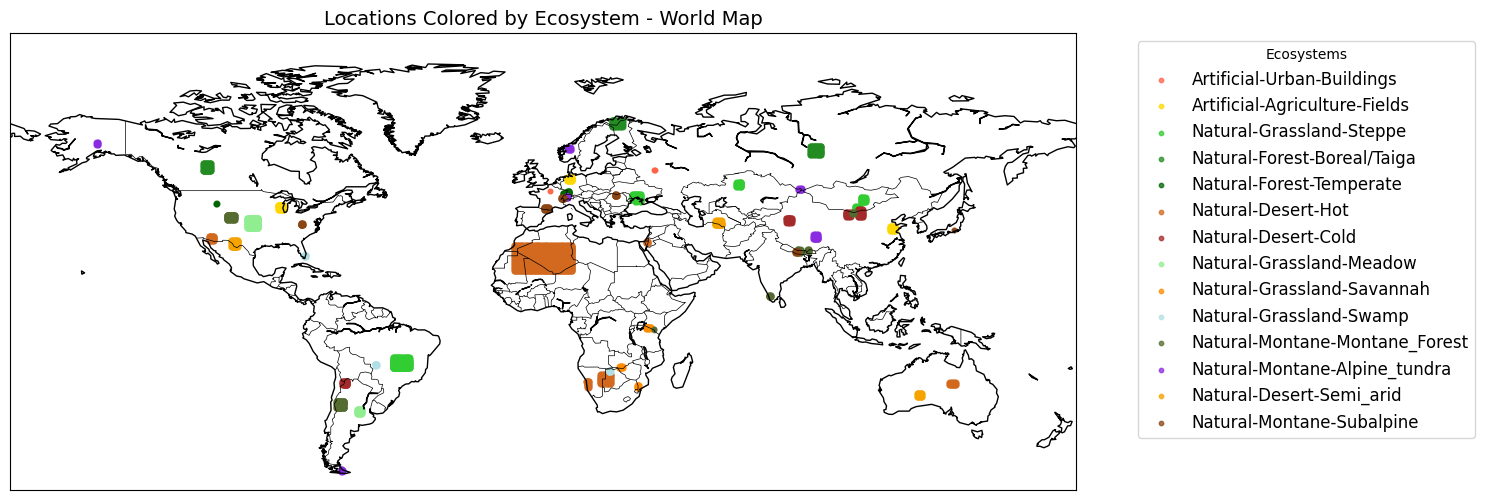

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.basemap import Basemap
import numpy as np

# Load the data
df = pd.read_csv('training_data.csv')

# Set up the figure and Basemap for the World
plt.figure(figsize=(15, 10))
m_projection = "gall"  # Gall-Peters projection
m = Basemap(projection=m_projection, llcrnrlat=-60, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180)

# Draw coastlines and countries for reference
m.drawcoastlines()
m.drawcountries()

# Define custom color palette for each ecosystem based on your provided list
ecosystem_color_map = {
    'Artificial-Urban-Buildings': '#FF6347',  # Red
    'Artificial-Agriculture-Fields': '#FFD700',  # Gold
    'Natural-Grassland-Steppe': '#32CD32',  # Lime Green
    'Natural-Forest-Boreal/Taiga': '#228B22',  # Forest Green
    'Natural-Forest-Temperate': '#006400',  # Dark Green
    'Natural-Desert-Hot': '#D2691E',  # Chocolate Brown
    'Natural-Desert-Cold': '#A52A2A',  # Brown
    'Natural-Grassland-Meadow': '#90EE90',  # Light Green
    'Natural-Grassland-Savannah': '#FF8C00',  # Dark Orange
    'Natural-Grassland-Swamp': '#B0E0E6',  # Powder Blue
    'Natural-Montane-Montane_Forest': '#556B2F',  # Dark Olive Green
    'Natural-Montane-Alpine_tundra': '#8A2BE2',  # Blue Violet
    'Natural-Desert-Semi_arid': '#F4A300',  # Orange Yellow
    'Natural-Montane-Subalpine': '#8B4513'   # Saddle Brown
}

# Create a list of unique ecosystems from the dataframe
unique_ecosystems = df['ecosystem'].unique()

# Plot each point, colored by ecosystem
scatter_objects = []  # To store scatter objects for the legend
for ecosystem in unique_ecosystems:
    ecosystem_data = df[df['ecosystem'] == ecosystem]
    x, y = m(ecosystem_data['lon'].values, ecosystem_data['lat'].values)
    # Get the color for this ecosystem from the predefined color map
    color = ecosystem_color_map.get(ecosystem, '#808080')  # Default to gray if not found
    # Create scatter for this ecosystem and add it to the legend
    scatter = m.scatter(x, y, color=color, s=10, alpha=0.75, label=ecosystem)
    scatter_objects.append(scatter)  # Store scatter object for later use in legend

# Add a title
plt.title("Locations Colored by Ecosystem - World Map", fontsize=14)

# Add a legend for the ecosystems
plt.legend(handles=scatter_objects, title="Ecosystems", loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=12)

# Show the plot
plt.tight_layout()  # Ensure the map fits well
plt.show()

# **Heatmap**

In [ ]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv('20241111_data_to_predict.csv')

# Convert categorical columns to numeric using one-hot encoding
df_encoded = pd.get_dummies(df, drop_first=True)

# Calculate the correlation matrix
correlation_matrix = df_encoded.corr()

# Print the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()
